# Semantic Segmentation with U-net and Linknet

Import libraries

In [ ]:
import os
import glob
import cv2

from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image

import numpy as np
from matplotlib import pyplot as plt

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras import backend as K
from keras.metrics import MeanIoU
from keras.utils import normalize

import tensorflow as tf

earlystopper = EarlyStopping(patience=5, verbose=1)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_directory = "/content/drive/MyDrive/Leukemia/unet2/train/rgb/"
mask_directory = "/content/drive/MyDrive/Leukemia/unet2/train/rgbmasks/"

In [ ]:
SIZE = 256
image_dataset = []
mask_dataset = []

Read all images from train folder and convert to array

In [ ]:
images = sorted([image_name for image_name in os.listdir(image_directory) if image_name.split('.')[1] == 'tiff'])

In [ ]:
for i, image_name in enumerate(images):
    if (image_name.split('.')[1] == 'tiff'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

In [ ]:
image_dataset = np.array(image_dataset)/255.
print(image_dataset.shape)

(230, 256, 256, 3)


In [ ]:
masks = sorted([image_name for image_name in os.listdir(mask_directory) if image_name.split('.')[1] == 'tiff'])

In [ ]:
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tiff'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

In [ ]:
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.
print(mask_dataset.shape)

(230, 256, 256, 1)


Sanity check to confirm all images are aligned with its masked images

In [ ]:
for i, image_name in enumerate(images):
    if (image_name.split('.')[1] == 'tiff'):
        print(f"Image filename: {image_name}, Mask filename: {masks[i]}")

Image filename: IMG_0001.tiff, Mask filename: IMG_m0001.tiff
Image filename: IMG_0002.tiff, Mask filename: IMG_m0002.tiff
Image filename: IMG_0003.tiff, Mask filename: IMG_m0003.tiff
Image filename: IMG_0004.tiff, Mask filename: IMG_m0004.tiff
Image filename: IMG_0005.tiff, Mask filename: IMG_m0005.tiff
Image filename: IMG_0006.tiff, Mask filename: IMG_m0006.tiff
Image filename: IMG_0007.tiff, Mask filename: IMG_m0007.tiff
Image filename: IMG_0008.tiff, Mask filename: IMG_m0008.tiff
Image filename: IMG_0009.tiff, Mask filename: IMG_m0009.tiff
Image filename: IMG_0010.tiff, Mask filename: IMG_m0010.tiff
Image filename: IMG_0011.tiff, Mask filename: IMG_m0011.tiff
Image filename: IMG_0012.tiff, Mask filename: IMG_m0012.tiff
Image filename: IMG_0013.tiff, Mask filename: IMG_m0013.tiff
Image filename: IMG_0014.tiff, Mask filename: IMG_m0014.tiff
Image filename: IMG_0015.tiff, Mask filename: IMG_m0015.tiff
Image filename: IMG_0016.tiff, Mask filename: IMG_m0016.tiff
Image filename: IMG_0017

## Data Augmentation

In [ ]:
images_to_generate=1150
seed_for_random = 2

In [ ]:
def rotation(image, seed):
    random.seed(seed)
    angle= random.randint(-180,180)
    r_img = rotate(image, angle, mode='reflect', reshape=False, order=0)
    return r_img

def h_flip(image, seed):
    hflipped_img= np.fliplr(image)
    return  hflipped_img

def v_flip(image, seed):
    vflipped_img= np.flipud(image)
    return vflipped_img

def v_transl(image, seed):
    random.seed(seed)
    n_pixels = random.randint(-64,64)
    vtranslated_img = np.roll(image, n_pixels, axis=0)
    return vtranslated_img

def h_transl(image, seed):
    random.seed(seed)
    n_pixels = random.randint(-64,64)
    htranslated_img = np.roll(image, n_pixels, axis=1)
    return htranslated_img

In [ ]:
transformations = {'rotate': rotation,
                      'horizontal flip': h_flip,
                      'vertical flip': v_flip,
                   'vertical shift': v_transl,
                   'horizontal shift': h_transl
                 }

In [ ]:
images=[] # to store paths of images from folder
masks=[]

In [ ]:
for im in os.listdir(image_directory):  # read image name from folder and append its path into "images" array
    images.append(os.path.join(image_directory,im))

for msk in os.listdir(mask_directory):  # read mask name from folder and append its path into "masks" array
    masks.append(os.path.join(mask_directory,msk))

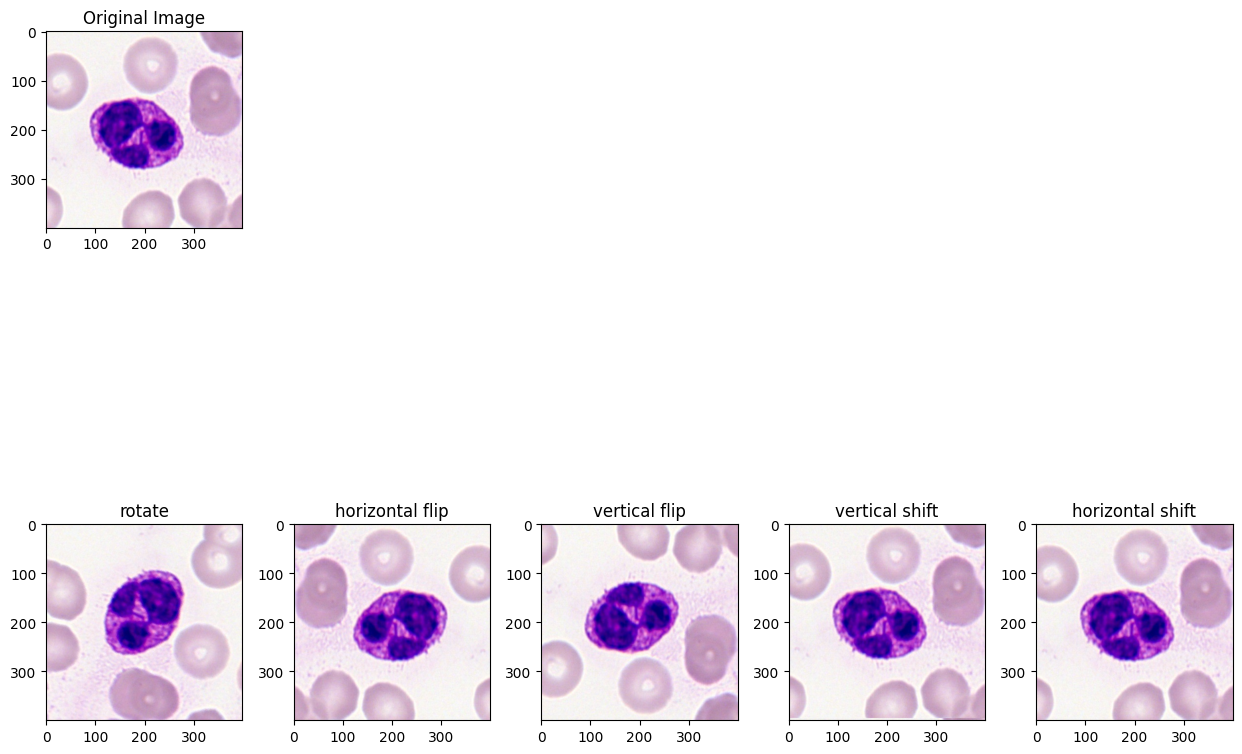

In [ ]:
import random
from scipy.ndimage import rotate
sample_index = 1
sample_image_path = images[sample_index]
sample_image = np.array(Image.open(sample_image_path))

# Display augmented images
num_augmentations = 5  # Number of augmented images to display
plt.figure(figsize=(15, 10))
plt.subplot(2, num_augmentations + 1, 1)
plt.imshow(sample_image)
plt.title("Original Image")

for i, (name, transformation) in enumerate(transformations.items(), start=1):
    augmented_image = transformation(sample_image, seed=i)
    plt.subplot(2, num_augmentations + 1, i + num_augmentations + 1)
    plt.imshow(augmented_image)
    plt.title(name)

plt.tight_layout()
plt.show()

In [ ]:
i=1   # variable to iterate till images_to_generate

while i<=images_to_generate:
  for number in range(0, len(images)):
    image = images[number]
    mask = masks[number]
    #print(image, mask)
    #image=random.choice(images) #Randomly select an image name
    original_image = cv2.imread(image)
    original_mask = cv2.imread(mask)
    transformed_image = None
    transformed_mask = None
    #print(i)
    n = 0       #variable to iterate till number of transformation to apply
    transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image

    while n <= transformation_count:
      key = random.choice(list(transformations)) #randomly choosing method to call
      seed = random.randint(1,100)  #Generate seed to supply transformation functions.
      transformed_image = transformations[key](original_image, seed)
      transformed_mask = transformations[key](original_mask, seed)
      n = n + 1

    new_image_path= "%s/augmented_image_%s.tiff" %(img_augmented_path, i)
    new_mask_path = "%s/augmented_mask_%s.tiff" %(msk_augmented_path, i)   #Do not save as JPG
    io.imsave(new_image_path, transformed_image)
    io.imsave(new_mask_path, transformed_mask)
    i =i+1

## U-net Segmentation with augmented data

In [ ]:
img_augmented_path="/content/drive/MyDrive/Leukemia/Augmented/train/rgb/" # path to store augmented images
msk_augmented_path="/content/drive/MyDrive/Leukemia/Augmented/train/rgbmask/" # path to store augmented masks

In [ ]:
SIZE = 256
image_dataset_aug = []
mask_dataset_aug = []

In [ ]:
images_aug = sorted([image_name for image_name in os.listdir(img_augmented_path) if image_name.split('.')[1] == 'tiff'])

In [ ]:
for i, image_name in enumerate(images_aug):
    if (image_name.split('.')[1] == 'tiff'):
        #print(image_directory+image_name)
        image = cv2.imread(img_augmented_path+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset_aug.append(np.array(image))

Image dataset contains 978 augmented images of size 256X256 in rgb

In [ ]:
image_dataset_aug = np.array(image_dataset_aug)/255.
print(image_dataset_aug.shape)

(978, 256, 256, 3)


In [ ]:
IMG_HEIGHT = image_dataset_aug.shape[1]
IMG_WIDTH  = image_dataset_aug.shape[2]
IMG_CHANNELS = image_dataset_aug.shape[3]

In [ ]:
masks_aug = sorted([image_name for image_name in os.listdir(msk_augmented_path) if image_name.split('.')[1] == 'tiff'])

In [ ]:
for i, image_name in enumerate(masks_aug):
    if (image_name.split('.')[1] == 'tiff'):
        #print(image_directory+image_name)
        image = cv2.imread(msk_augmented_path+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset_aug.append(np.array(image))

Mask dataset contains 978 augmented masks of size 256x256 in black and white

In [ ]:
mask_dataset_aug = np.expand_dims((np.array(mask_dataset_aug)),3) /255.
print(mask_dataset_aug.shape)

(978, 256, 256, 1, 3)


In [ ]:
mask_dataset_aug = mask_dataset_aug[..., 0]
print(mask_dataset_aug.shape)

(978, 256, 256, 1)


Sanity check

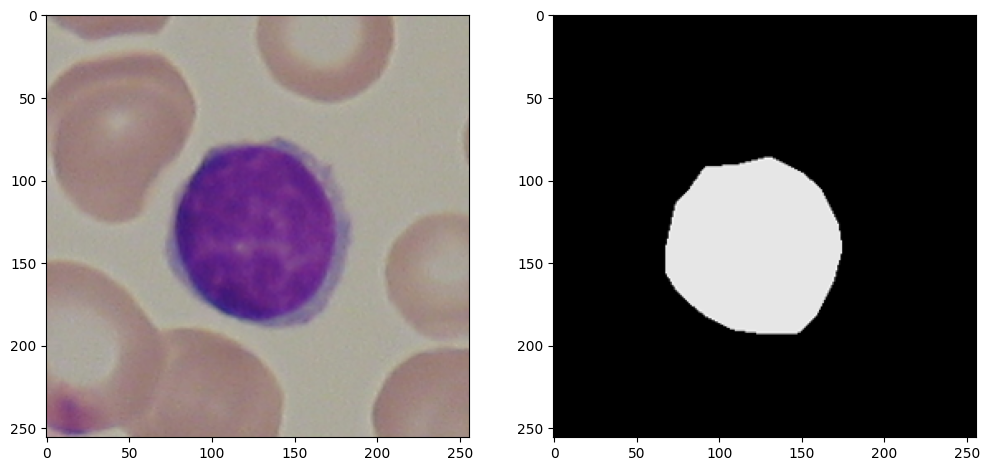

In [ ]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset_aug))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset_aug[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset_aug[image_number], (256, 256)), cmap='gray')
plt.show()

In [ ]:
for i, image_name in enumerate(images_aug):
    if (image_name.split('.')[1] == 'tiff'):
        print(f"Image filename: {image_name}, Mask filename: {masks_aug[i]}")

Image filename: augmented_image_1.tiff, Mask filename: augmented_mask_1.tiff
Image filename: augmented_image_10.tiff, Mask filename: augmented_mask_10.tiff
Image filename: augmented_image_100.tiff, Mask filename: augmented_mask_100.tiff
Image filename: augmented_image_1000.tiff, Mask filename: augmented_mask_1000.tiff
Image filename: augmented_image_1001.tiff, Mask filename: augmented_mask_1001.tiff
Image filename: augmented_image_1002.tiff, Mask filename: augmented_mask_1002.tiff
Image filename: augmented_image_1003.tiff, Mask filename: augmented_mask_1003.tiff
Image filename: augmented_image_1004.tiff, Mask filename: augmented_mask_1004.tiff
Image filename: augmented_image_1005.tiff, Mask filename: augmented_mask_1005.tiff
Image filename: augmented_image_1006.tiff, Mask filename: augmented_mask_1006.tiff
Image filename: augmented_image_1007.tiff, Mask filename: augmented_mask_1007.tiff
Image filename: augmented_image_1008.tiff, Mask filename: augmented_mask_1008.tiff
Image filename: 

**Build U-net model**


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [ ]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

In [ ]:
def simple_unet_model_with_jacard(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    #model.compile(optim, total_loss, metrics=metrics)

    model.summary()

    return model

In [ ]:
def get_jacard_model():
    return simple_unet_model_with_jacard(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model_jacard = get_jacard_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

Save model checkpoint if needed

In [ ]:
filepath_checkpoint_unet="/content/drive/MyDrive/Segmentation model/checkpoint/ResUnet-weights-improvement-{epoch:02d}.hdf5"

In [ ]:
checkpoint = ModelCheckpoint(filepath_checkpoint_unet, monitor='val_iou_score', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset_aug, mask_dataset_aug, test_size = 0.30, random_state = 0, shuffle = False)

In [ ]:
history_jacard = model_jacard.fit(X_train, y_train,
                    batch_size = 6,
                    verbose=1,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    #callbacks=callbacks_list,
                    shuffle=False)

Epoch 1/20
114/114 [==============================] - 32s 91ms/step - loss: 0.2800 - accuracy: 0.7621 - val_loss: 0.1671 - val_accuracy: 0.8229
Epoch 2/20
114/114 [==============================] - 9s 79ms/step - loss: 0.1614 - accuracy: 0.8200 - val_loss: 0.1661 - val_accuracy: 0.8224
Epoch 3/20
114/114 [==============================] - 9s 80ms/step - loss: 0.1585 - accuracy: 0.8201 - val_loss: 0.1652 - val_accuracy: 0.8228
Epoch 4/20
114/114 [==============================] - 8s 74ms/step - loss: 0.1538 - accuracy: 0.8196 - val_loss: 0.1680 - val_accuracy: 0.8229
Epoch 5/20
114/114 [==============================] - 9s 80ms/step - loss: 0.1903 - accuracy: 0.8203 - val_loss: 0.1815 - val_accuracy: 0.8228
Epoch 6/20
114/114 [==============================] - 9s 80ms/step - loss: 0.1670 - accuracy: 0.8201 - val_loss: 0.1933 - val_accuracy: 0.8227
Epoch 7/20
114/114 [==============================] - 8s 75ms/step - loss: 0.1696 - accuracy: 0.8203 - val_loss: 0.2120 - val_accuracy: 0.822

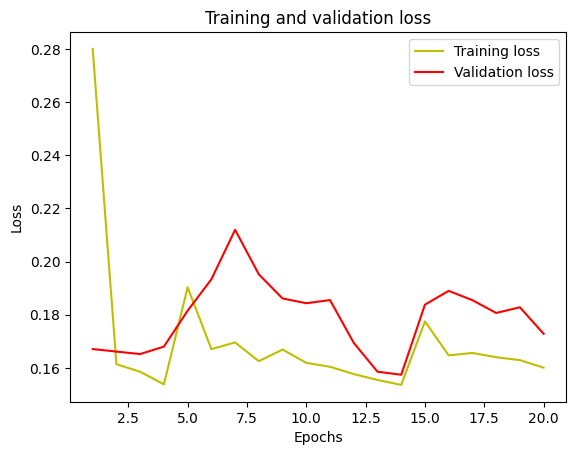

In [ ]:
loss = history_jacard.history['loss']
val_loss = history_jacard.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

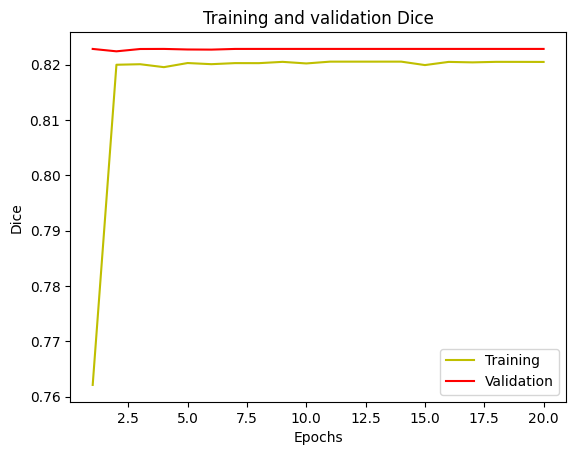

In [ ]:
#acc = history_jacard.history['dice_coef']
acc = history_jacard.history['accuracy']
#val_acc = history_jacard.history['val_dice_coef']
val_acc = history_jacard.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training')
plt.plot(epochs, val_acc, 'r', label='Validation')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

Save U-net model

In [ ]:
model_jacard.save('/content/drive/MyDrive/Segmentation model/Unet_jacard20epochs_aug.hdf5')

Load U-net model

In [ ]:
model_path_Unet = "/content/drive/MyDrive/Segmentation model/Unet_jacard_20epochs.hdf5"
model_Unet = tf.keras.models.load_model(model_path_Unet, compile=False)

In [ ]:
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model_Unet.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 29ms/step


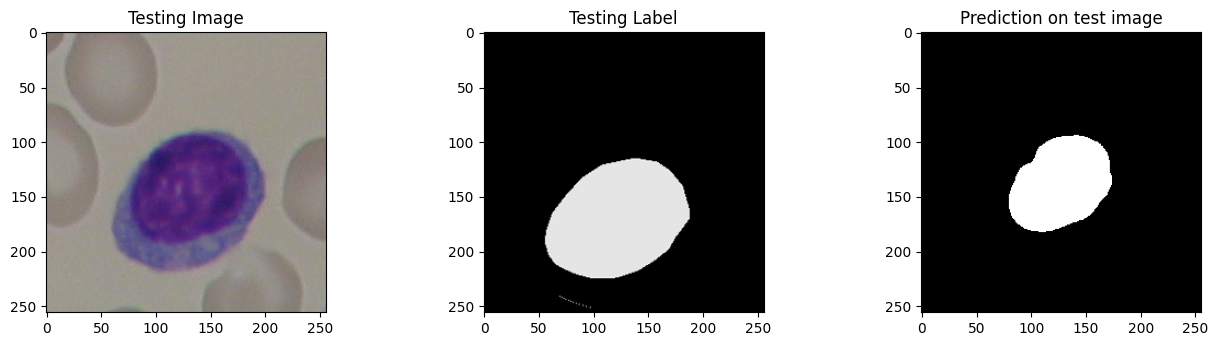

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

## Linknet segmentation with augmented data

In [ ]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


In [ ]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras

In [ ]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)
n_classes=2

In [ ]:
activation='sigmoid'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
model1 = sm.Linknet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

85521592/85521592 [==============================] - 1s 0us/step


In [ ]:
model1.compile(optimizer='adam', loss=total_loss, metrics=metrics)
print(model1.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

In [ ]:
X_train1 = preprocess_input1(image_dataset_aug)
X_test1 = preprocess_input1(X_test)

In [ ]:
history1=model1.fit(X_train1,
          mask_dataset_aug,
          batch_size=6,
          epochs=20,
          verbose=1,
          #callbacks=callbacks_list,
          validation_data=(X_test1, y_test))

Save Linknet model

In [ ]:
model1.save('/content/drive/MyDrive/Segmentation model/Linknet_resnet34_20epochs_aug.hdf5')

Load Linknet model

In [ ]:
model_path_Linknet = "/content/drive/MyDrive/Segmentation model/Linknet_resnet34_50epochs_aug.hdf5"
model_Linknet = tf.keras.models.load_model(model_path_Linknet, compile=False)

In [ ]:
import random
import numpy as np

test_img_number = random.randint(0, image_dataset.shape[0]-1)
test_img = image_dataset[test_img_number]
ground_truth=mask_dataset[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction_Unet = (model_Unet.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
prediction_Linknet = (model_Linknet.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 23ms/step


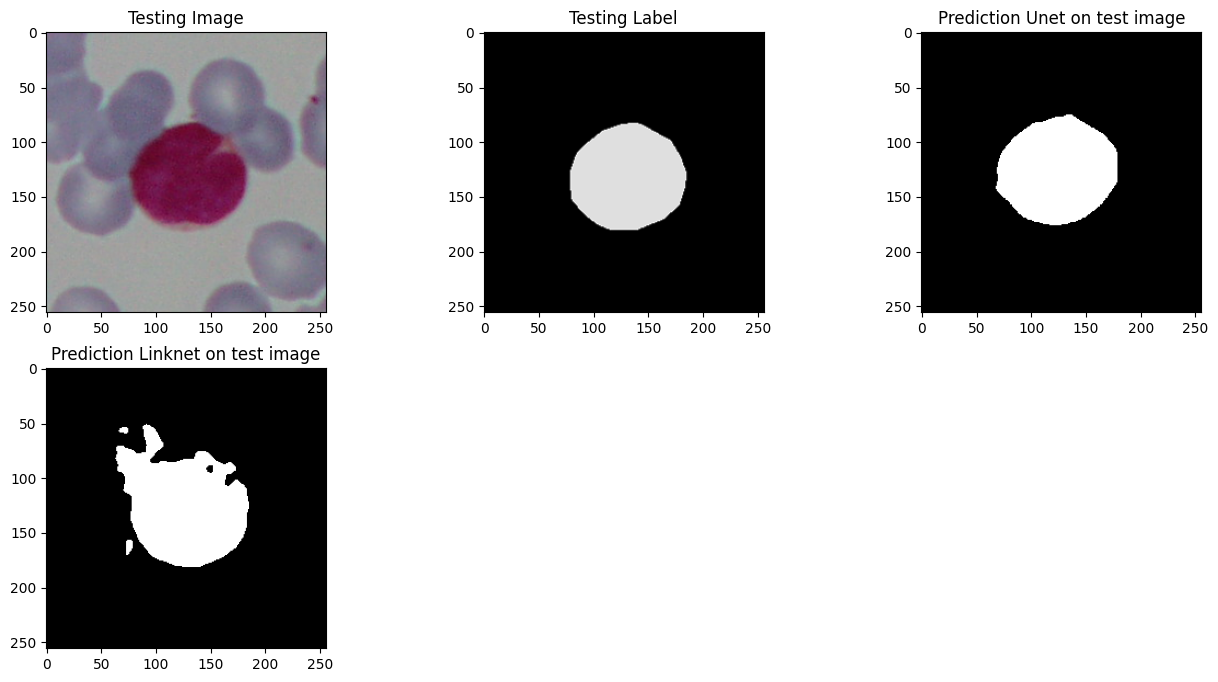

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction Unet on test image')
plt.imshow(prediction_Unet, cmap='gray')
plt.subplot(234)
plt.title('Prediction Linknet on test image')
plt.imshow(prediction_Linknet, cmap='gray')


plt.show()

In [ ]:
import pandas as pd
from keras.metrics import MeanIoU

model_list = [ model_Unet, model_Linknet]
model_names = [ "Unet", "Linknet Resnet34"]

n_classes = 2
IoU_results = []

for model, model_name in zip(model_list, model_names):
    IoU_values = []

    for img in range(0, image_dataset.shape[0]):
        temp_img = image_dataset[img]
        ground_truth = mask_dataset[img]
        temp_img_input = np.expand_dims(temp_img, 0)

        prediction = (model.predict(temp_img_input)[0, :, :, 0] > 0.5).astype(np.uint8)

        IoU_metric = MeanIoU(num_classes=n_classes)
        IoU_metric.update_state(ground_truth[:, :, 0], prediction)
        IoU = IoU_metric.result().numpy()
        IoU_values.append(IoU)

    df = pd.DataFrame(IoU_values, columns=["IoU"])
    df = df[df.IoU != 1.0]
    mean_IoU = df.mean().values[0]

    IoU_results.append((model_name, mean_IoU))

for model_name, mean_iou in IoU_results:
    print(f"{model_name} Mean IoU is: {mean_iou}")

1/1 [==============================] - 0s 23ms/step
Unet Mean IoU is: 0.4137490689754486
Linknet Resnet34 Mean IoU is: 0.4172908067703247
